## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [54]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [55]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [56]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [57]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [58]:
len(fmnist_dataset_test)

10000

In [59]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [60]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 50),
            nn.ReLU(),
            nn.Linear(50, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [61]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 50]          39,250
              ReLU-3                   [-1, 50]               0
            Linear-4                   [-1, 10]             510
        LogSoftmax-5                   [-1, 10]               0
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.15
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


Your experiments come here:

In [62]:
model = TinyNeuralNetwork().to(device)
# YOUR CODE HERE
opt = torch.optim.Adam(model.parameters())
# YOUR CODE HERE
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here

In [63]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [76]:
def train_data(model, train_loader, test_loader, loss_funct, opt, n_epoch):
  train_loss = []
  test_loss = []
  train_accuracy = []
  test_accuracy = []

  for epoch in tqdm(range(n_epoch)):
    epoch_train_loss = []
    epoch_test_loss = []
    epoch_test_accuracy = []
    epoch_train_accuracy = []

    model.train(True)
    # Train model using train data
    for X_batch, y_batch in train_loader:
      opt.zero_grad()
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)
      predict = model.forward(X_batch)
      loss = loss_func(predict, y_batch)
      loss.backward()
      opt.step()

      epoch_train_loss.append(loss.item())
      y_pred = predict.argmax(axis=1)
      epoch_train_accuracy.append(accuracy_score(y_pred.cpu().numpy(), y_batch.cpu().numpy()))

    # Train model using test data
    model.train(False)
    with torch.no_grad():
      for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        predict = model.forward(X_batch)
        loss = loss_func(predict, y_batch)
        
        epoch_test_loss.append(loss.item())
        y_pred = predict.argmax(axis=1)
        epoch_test_accuracy.append(accuracy_score(y_pred.cpu().numpy(), y_batch.cpu().numpy()))
    
    test_accuracy.append(np.mean(epoch_test_accuracy))
    train_accuracy.append(np.mean(epoch_train_accuracy))
    train_loss.append(np.mean(epoch_train_loss))
    test_loss.append(np.mean(epoch_test_loss))

    print(f'Epoch {epoch} has accurcy score of test data: {test_accuracy[-1]:.3f}')


In [77]:
train_data(model, train_loader, test_loader, loss_func, opt, 10) # Number of epoch is 10

 10%|█         | 1/10 [00:07<01:07,  7.52s/it]

Epoch 0 has accurcy score of test data: 0.884


 20%|██        | 2/10 [00:14<00:59,  7.48s/it]

Epoch 1 has accurcy score of test data: 0.890


 30%|███       | 3/10 [00:22<00:52,  7.57s/it]

Epoch 2 has accurcy score of test data: 0.887


 40%|████      | 4/10 [00:30<00:45,  7.57s/it]

Epoch 3 has accurcy score of test data: 0.884


 50%|█████     | 5/10 [00:38<00:39,  7.80s/it]

Epoch 4 has accurcy score of test data: 0.892


 60%|██████    | 6/10 [00:46<00:30,  7.74s/it]

Epoch 5 has accurcy score of test data: 0.885


 70%|███████   | 7/10 [00:53<00:23,  7.69s/it]

Epoch 6 has accurcy score of test data: 0.895


 80%|████████  | 8/10 [01:01<00:15,  7.64s/it]

Epoch 7 has accurcy score of test data: 0.893


 90%|█████████ | 9/10 [01:09<00:07,  7.84s/it]

Epoch 8 has accurcy score of test data: 0.893


100%|██████████| 10/10 [01:16<00:00,  7.70s/it]

Epoch 9 has accurcy score of test data: 0.894


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [78]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [79]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                   [-1, 64]          16,448
              ReLU-5                   [-1, 64]               0
            Linear-6                   [-1, 10]             650
Total params: 218,058
Trainable params: 218,058
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.83
Estimated Total Size (MB): 0.85
----------------------------------------------------------------


In [80]:
model = OverfittingNeuralNetwork().to(device)
# YOUR CODE HERE
opt = torch.optim.Adam(model.parameters())
# YOUR CODE HERE
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here

In [83]:
def train_data_overfit(model, train_loader, test_loader, loss_funct, opt, n_epoch):
  train_loss = []
  test_loss = []
  train_accuracy = []
  test_accuracy = []

  for epoch in tqdm(range(n_epoch)):
    epoch_train_loss = []
    epoch_test_loss = []
    epoch_test_accuracy = []
    epoch_train_accuracy = []

    model.train(True)
    # Train model using train data
    for X_batch, y_batch in train_loader:
      opt.zero_grad()
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)
      predict = model(X_batch)
      loss = loss_func(predict, y_batch)
      loss.backward()
      opt.step()

      epoch_train_loss.append(loss.item())
      y_pred = predict.max(1)[1].data
      epoch_train_accuracy.append(accuracy_score(y_pred.cpu().numpy(), y_batch.cpu().numpy()))

    # Train model using test data
    model.train(False)
    with torch.no_grad():
      for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        predict = model(X_batch)
        loss = loss_func(predict, y_batch)
        
        epoch_test_loss.append(loss.item())
        y_pred = predict.max(1)[1].data
        epoch_test_accuracy.append(accuracy_score(y_pred.cpu().numpy(), y_batch.cpu().numpy()))
    
    test_accuracy.append(np.mean(epoch_test_accuracy))
    train_accuracy.append(np.mean(epoch_train_accuracy))
    train_loss.append(np.mean(epoch_train_loss))
    test_loss.append(np.mean(epoch_test_loss))

    print(f'Epoch {epoch} has accurcy score of test data: {test_accuracy[-1]:.3f}')
    print(f'Epoch {epoch} has accurcy score of train data: {train_accuracy[-1]:.3f}')


  # print(f'Max accuracy score of test data: {max(test_accuracy)} at {np.argmax(test_accuracy)} epoch')
  plt.figure(figsize=(15, 6))
  plt.title('Loss')
  plt.xlabel("epoch")
  plt.ylabel("loss value")
  plt.plot(train_loss, label='train')
  plt.plot(test_loss, label='test')
  plt.legend()

  plt.figure(figsize=(15, 6))
  plt.title('Accuracy score')
  plt.xlabel("epoch")
  plt.ylabel("accuracy score")
  plt.plot(train_accuracy, label='train')
  plt.plot(test_accuracy, label='test')
  plt.legend()


 10%|█         | 1/10 [00:07<01:07,  7.49s/it]

Epoch 0 has accurcy score of test data: 0.883
Epoch 0 has accurcy score of train data: 0.911


 20%|██        | 2/10 [00:14<00:59,  7.49s/it]

Epoch 1 has accurcy score of test data: 0.886
Epoch 1 has accurcy score of train data: 0.914


 30%|███       | 3/10 [00:22<00:52,  7.50s/it]

Epoch 2 has accurcy score of test data: 0.889
Epoch 2 has accurcy score of train data: 0.917


 40%|████      | 4/10 [00:30<00:45,  7.53s/it]

Epoch 3 has accurcy score of test data: 0.886
Epoch 3 has accurcy score of train data: 0.921


 50%|█████     | 5/10 [00:37<00:37,  7.57s/it]

Epoch 4 has accurcy score of test data: 0.889
Epoch 4 has accurcy score of train data: 0.922


 60%|██████    | 6/10 [00:45<00:30,  7.53s/it]

Epoch 5 has accurcy score of test data: 0.888
Epoch 5 has accurcy score of train data: 0.926


 70%|███████   | 7/10 [00:52<00:22,  7.53s/it]

Epoch 6 has accurcy score of test data: 0.886
Epoch 6 has accurcy score of train data: 0.928


 80%|████████  | 8/10 [01:00<00:15,  7.57s/it]

Epoch 7 has accurcy score of test data: 0.886
Epoch 7 has accurcy score of train data: 0.929


 90%|█████████ | 9/10 [01:07<00:07,  7.55s/it]

Epoch 8 has accurcy score of test data: 0.884
Epoch 8 has accurcy score of train data: 0.931


100%|██████████| 10/10 [01:15<00:00,  7.58s/it]

Epoch 9 has accurcy score of test data: 0.891
Epoch 9 has accurcy score of train data: 0.934


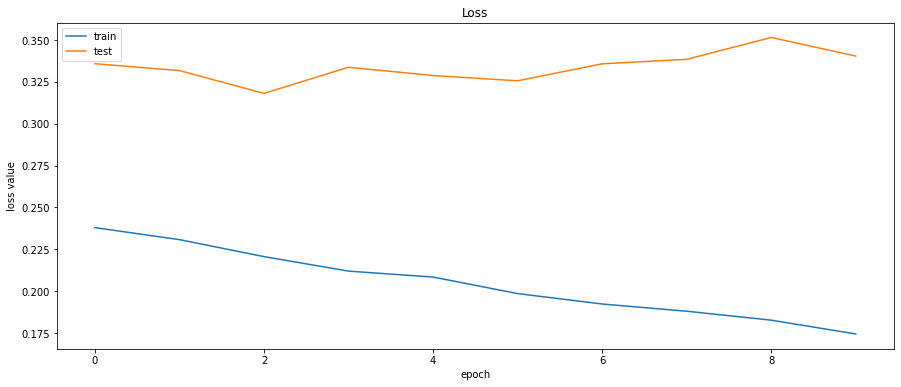

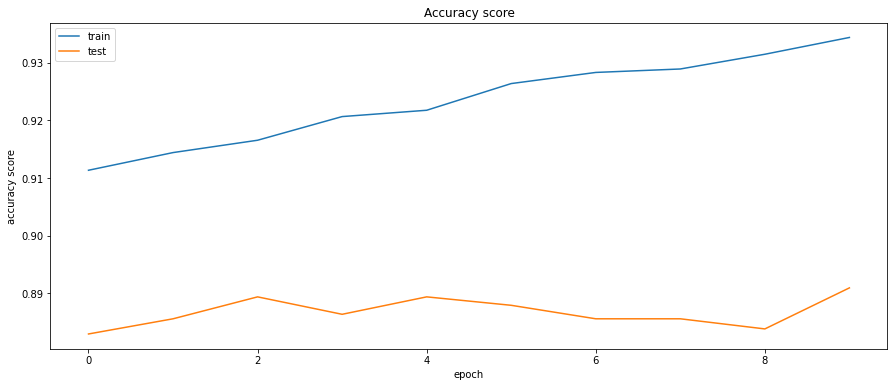

In [84]:
train_data_overfit(model, train_loader, test_loader, loss_func, opt, 10) # Number of epoch is 10

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [111]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            # Here i used Dropout
            nn.Linear(input_shape, 256),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [113]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
           Dropout-3                  [-1, 256]               0
              ReLU-4                  [-1, 256]               0
       BatchNorm1d-5                  [-1, 256]             512
            Linear-6                  [-1, 128]          32,896
           Dropout-7                  [-1, 128]               0
              ReLU-8                  [-1, 128]               0
       BatchNorm1d-9                  [-1, 128]             256
           Linear-10                   [-1, 10]           1,290
Total params: 235,914
Trainable params: 235,914
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.90
Estimated T

In [114]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here

In [115]:
def train_data_fix(model, train_loader, test_loader, loss_funct, opt, n_epoch):
  train_loss = []
  test_loss = []
  train_accuracy = []
  test_accuracy = []

  for epoch in tqdm(range(n_epoch)):
    epoch_train_loss = []
    epoch_test_loss = []
    epoch_test_accuracy = []
    epoch_train_accuracy = []

    model.train(True)
    # Train model using train data
    for X_batch, y_batch in train_loader:
      opt.zero_grad()
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)
      predict = model(X_batch)
      loss = loss_func(predict, y_batch)
      loss.backward()
      opt.step()

      epoch_train_loss.append(loss.item())
      y_pred = predict.max(1)[1].data
      epoch_train_accuracy.append(accuracy_score(y_pred.cpu().numpy(), y_batch.cpu().numpy()))

    # Train model using test data
    model.train(False)
    with torch.no_grad():
      for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        predict = model(X_batch)
        loss = loss_func(predict, y_batch)
        
        epoch_test_loss.append(loss.item())
        y_pred = predict.max(1)[1].data
        epoch_test_accuracy.append(accuracy_score(y_pred.cpu().numpy(), y_batch.cpu().numpy()))
    
    test_accuracy.append(np.mean(epoch_test_accuracy))
    train_accuracy.append(np.mean(epoch_train_accuracy))
    train_loss.append(np.mean(epoch_train_loss))
    test_loss.append(np.mean(epoch_test_loss))

    print(f'Epoch {epoch} has accurcy score of test data: {test_accuracy[-1]:.3f}')
    print(f'Epoch {epoch} has accurcy score of train data: {train_accuracy[-1]:.3f}')


  # print(f'Max accuracy score of test data: {max(test_accuracy)} at {np.argmax(test_accuracy)} epoch')
  plt.figure(figsize=(15, 6))
  plt.title('Loss')
  plt.xlabel("epoch")
  plt.ylabel("loss value")
  plt.plot(train_loss, label='train')
  plt.plot(test_loss, label='test')
  plt.legend()

  plt.figure(figsize=(15, 6))
  plt.title('Accuracy score')
  plt.xlabel("epoch")
  plt.ylabel("accuracy score")
  plt.plot(train_accuracy, label='train')
  plt.plot(test_accuracy, label='test')
  plt.legend()


 10%|█         | 1/10 [00:08<01:12,  8.10s/it]

Epoch 0 has accurcy score of test data: 0.845
Epoch 0 has accurcy score of train data: 0.808


 20%|██        | 2/10 [00:16<01:07,  8.47s/it]

Epoch 1 has accurcy score of test data: 0.853
Epoch 1 has accurcy score of train data: 0.839


 30%|███       | 3/10 [00:24<00:58,  8.30s/it]

Epoch 2 has accurcy score of test data: 0.859
Epoch 2 has accurcy score of train data: 0.849


 40%|████      | 4/10 [00:33<00:49,  8.23s/it]

Epoch 3 has accurcy score of test data: 0.860
Epoch 3 has accurcy score of train data: 0.852


 50%|█████     | 5/10 [00:41<00:41,  8.39s/it]

Epoch 4 has accurcy score of test data: 0.865
Epoch 4 has accurcy score of train data: 0.856


 60%|██████    | 6/10 [00:49<00:33,  8.31s/it]

Epoch 5 has accurcy score of test data: 0.869
Epoch 5 has accurcy score of train data: 0.857


 70%|███████   | 7/10 [00:57<00:24,  8.22s/it]

Epoch 6 has accurcy score of test data: 0.868
Epoch 6 has accurcy score of train data: 0.860


 80%|████████  | 8/10 [01:05<00:16,  8.13s/it]

Epoch 7 has accurcy score of test data: 0.866
Epoch 7 has accurcy score of train data: 0.864


 90%|█████████ | 9/10 [01:14<00:08,  8.17s/it]

Epoch 8 has accurcy score of test data: 0.869
Epoch 8 has accurcy score of train data: 0.866


100%|██████████| 10/10 [01:22<00:00,  8.21s/it]

Epoch 9 has accurcy score of test data: 0.876
Epoch 9 has accurcy score of train data: 0.870


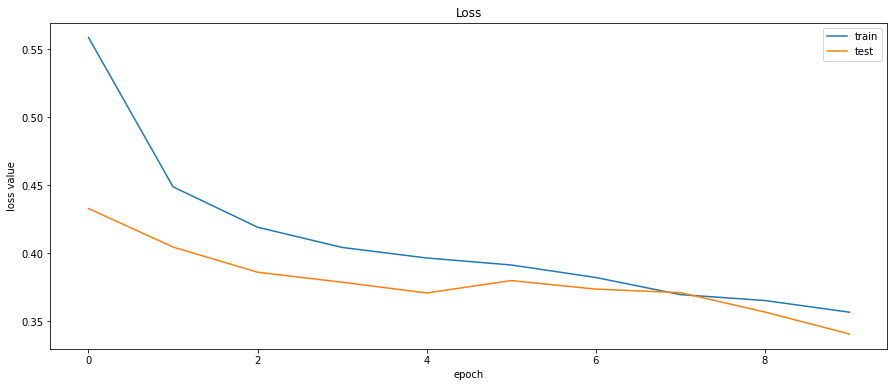

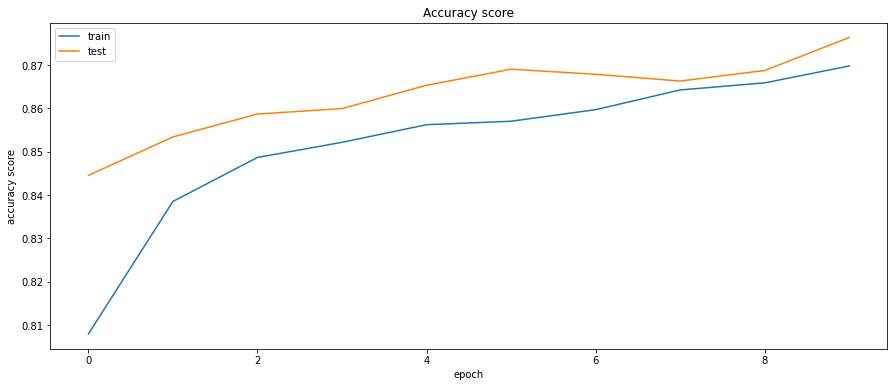

In [116]:
train_data_fix(model, train_loader, test_loader, loss_func, opt, 10)

### Conclusions:
_Write down small report with your conclusions and your ideas._
If i add drop out, batchnorm to the linear model then overfitting can be avoided